In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/iris")

print("Path to dataset files:", path)

100%|██████████| 3.60k/3.60k [00:00<00:00, 3.69MB/s]

Extracting model files...
Path to dataset files: C:\Users\OMEN\.cache\kagglehub\datasets\uciml\iris\versions\2


In [2]:
# Setup: libs, style, configuration (Iris path customized)
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (7, 4)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Customized input path for the attached Iris dataset
INPUT_CSV = r"C:\Users\OMEN\.cache\kagglehub\datasets\uciml\iris\versions\2\Iris.csv"

RANDOM_STATE = 42
TEST_SIZE = 0.2

assert os.path.exists(INPUT_CSV), f"File not found: {INPUT_CSV}"


In [3]:
# Load Iris and prepare features/target
df = pd.read_csv(INPUT_CSV)

# Drop ID-like column if present
if "Id" in df.columns:
    df = df.drop(columns=["Id"])

# Target and features
assert "Species" in df.columns, "Expected 'Species' column not found."
target_col = "Species"
y_raw = df[target_col].astype(str)
X = df.drop(columns=[target_col])

# Label-encode target classes
le = LabelEncoder()
y = le.fit_transform(y_raw)

print("Shape:", X.shape, "| Classes:", list(le.classes_))
display(df.head())


Shape: (150, 4) | Classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Preprocess: impute + scale (KNN requires normalization/standardization)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()  # usually empty for Iris

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),  # MinMaxScaler() is also valid for KNN
])

# If any non-numeric columns exist, one-hot encode them (unlikely for Iris)
from sklearn.preprocessing import OneHotEncoder
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop"
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train/Test:", X_train.shape, X_test.shape)


Train/Test: (120, 4) (30, 4)


K=5  Accuracy: 0.9667


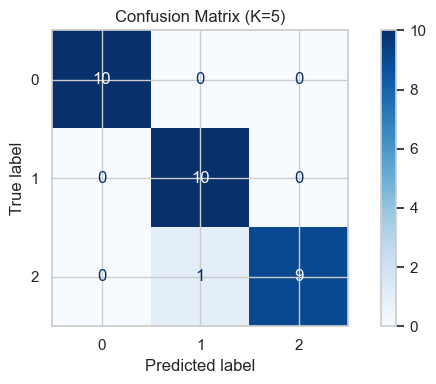

In [5]:
# Baseline KNN (K=5)
K = 5
knn = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", KNeighborsClassifier(n_neighbors=K, weights="distance"))
])
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"K={K}  Accuracy: {acc:.4f}")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (K={K})")
plt.tight_layout()
plt.show()


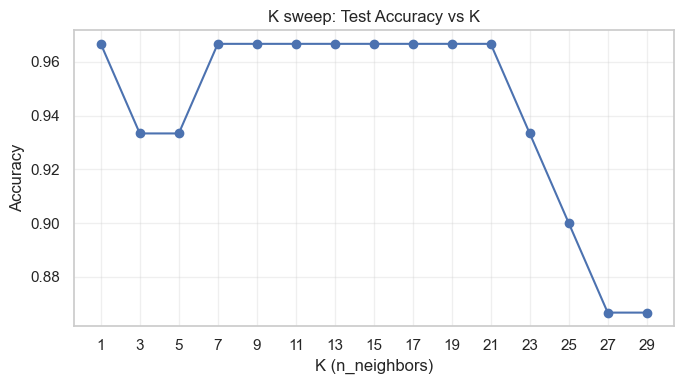

Best K by test accuracy: 1 (Accuracy=0.9667)


In [6]:
# Sweep K to choose an operating point
k_values = list(range(1, 31, 2))
accs = []

for k in k_values:
    model = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", KNeighborsClassifier(n_neighbors=k, weights="uniform"))
    ])
    model.fit(X_train, y_train)
    accs.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(k_values, accs, marker="o")
plt.xlabel("K (n_neighbors)")
plt.ylabel("Accuracy")
plt.title("K sweep: Test Accuracy vs K")
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_k = k_values[int(np.argmax(accs))]
print(f"Best K by test accuracy: {best_k} (Accuracy={max(accs):.4f})")


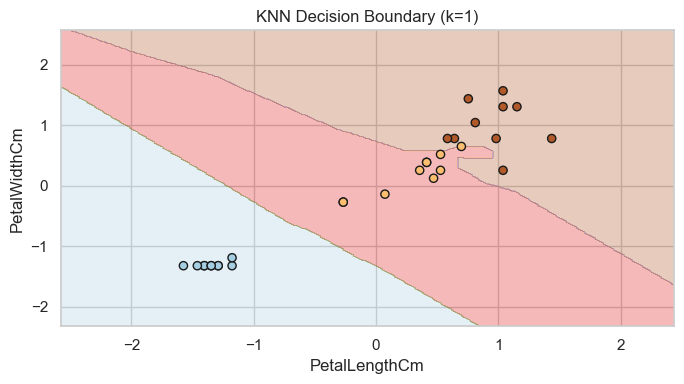

In [7]:
# Decision boundary: use PetalLengthCm & PetalWidthCm if present; else use PCA to 2D
use_pair = all(c in X.columns for c in ["PetalLengthCm","PetalWidthCm"])

if use_pair:
    feat2 = ["PetalLengthCm","PetalWidthCm"]
    X2_train = X_train[feat2].copy()
    X2_test  = X_test[feat2].copy()
    # Scale for KNN boundaries
    scaler2 = StandardScaler().fit(X2_train)
    X2_train_s = pd.DataFrame(scaler2.transform(X2_train), index=X2_train.index, columns=feat2)
    X2_test_s  = pd.DataFrame(scaler2.transform(X2_test),  index=X2_test.index,  columns=feat2)
else:
    from sklearn.decomposition import PCA
    scaler2 = StandardScaler().fit(X_train[num_cols])
    X_train_num = pd.DataFrame(scaler2.transform(X_train[num_cols]), index=X_train.index)
    X_test_num  = pd.DataFrame(scaler2.transform(X_test[num_cols]),  index=X_test.index)
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2_train_s = pd.DataFrame(pca.fit_transform(X_train_num), index=X_train.index, columns=["PC1","PC2"])
    X2_test_s  = pd.DataFrame(pca.transform(X_test_num),  index=X_test.index,  columns=["PC1","PC2"])
    feat2 = X2_train_s.columns.tolist()

# Train 2D KNN purely for visualization
knn2d = KNeighborsClassifier(n_neighbors=best_k, weights="uniform")
knn2d.fit(X2_train_s, y_train)

# Plot decision boundary
from sklearn.inspection import DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(
    knn2d, X2_test_s, response_method="predict", cmap=plt.cm.Paired, alpha=0.3, grid_resolution=300
)
plt.scatter(X2_test_s.iloc[:, 0], X2_test_s.iloc[:, 1], c=y_test, edgecolor="k", cmap=plt.cm.Paired, s=35)
plt.xlabel(feat2[0]); plt.ylabel(feat2[1])
plt.title(f"KNN Decision Boundary (k={best_k})")
plt.tight_layout()
plt.show()


In [8]:
# Optional: try different distance metrics and a quick 5-fold CV estimate
from sklearn.model_selection import cross_val_score, StratifiedKFold

def eval_metric(k=best_k, p=2, weights="uniform"):
    model = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=p, weights=weights))
    ])
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

print("Euclidean (p=2) test accuracy:", eval_metric(k=best_k, p=2))
print("Manhattan  (p=1) test accuracy:", eval_metric(k=best_k, p=1))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
model_cv = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", KNeighborsClassifier(n_neighbors=best_k, weights="uniform"))
])
cv_scores = cross_val_score(model_cv, X, y, cv=cv, scoring="accuracy")
print(f"5-fold CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Euclidean (p=2) test accuracy: 0.9666666666666667
Manhattan  (p=1) test accuracy: 0.9666666666666667
5-fold CV accuracy: 0.9333 ± 0.0596
